In [1]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from torch.distributions import Normal
import random
import time
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

#####################  hyper parameters  ####################

MAX_EPISODES = 3001              
MAX_EP_STEPS = 75               

RENDER = False

LOAD_MEM = False
LOAD_MODEL = False
LOAD_FOLDER_NAME = '2450epi'

LOAD_PRETRAIN = False

CHECK_POINT_EPI = 50


ENV_NAME = 'OpenCabinetDrawer-v0'       
SEED = 123                      

var = 5
var_low_bound = 0.05



In [2]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,hidden_dim):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.hidden_dim = hidden_dim
        self.pointer = 0                                                                         # exp buffer指针
        #self.lr_a = 0.001                                                                      # learning rate for actor
        #self.lr_c = 0.001                                                                       # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.001                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        self.Success_record = np.zeros(MAX_EPISODES)
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound,hidden_size):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                
                self.linear1 = nn.Linear(s_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear4 = nn.Linear(hidden_size, a_dim)
                
                
                self.linear4.weight.data.uniform_(-0.03, 0.03)
                self.linear4.bias.data.uniform_(-0.03, 0.03)
#                 self.fc1 = nn.Linear(s_dim,256)
#                 self.fc1.weight.data.normal_(0,0.1)          # initialization
                
#                 self.fc2 = nn.Linear(256,512)
#                 self.fc2.weight.data.normal_(0,0.1)
#                                
#                 self.fc3 = nn.Linear(512,256)
#                 self.fc3.weight.data.normal_(0,0.1)
                
#                 self.out = nn.Linear(256,a_dim)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.relu(self.linear3(x))
                x = F.tanh(self.linear4(x))
                
#                 x = self.fc1(x)
#                 x = F.relu(x)
#                  
#                 x = self.fc2(x)
#                 x = F.relu(x)
                
#                 x = self.fc3(x)
#                 x = F.relu(x)
                
#                 x = self.out(x)
#                 x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim,hidden_size):
                super(CNet,self).__init__()
                
                self.linear1 = nn.Linear(s_dim + a_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
#                 self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, 1)
                

                self.linear3.weight.data.uniform_(-0.03,0.03)
                self.linear3.bias.data.uniform_(-0.03,0.03)

#                 self.fcs1 = nn.Linear(s_dim,256)
#                 self.fcs1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs2 = nn.Linear(256,512)
#                 self.fcs2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs3 = nn.Linear(512,256)
#                 self.fcs3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01) 
                
#                 self.fca1 = nn.Linear(a_dim,256)
#                 self.fca1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fca2 = nn.Linear(256,512)
#                 self.fca2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)              
                
#                 self.fca3 = nn.Linear(512,256)
#                 self.fca3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.out = nn.Linear(256,1)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
        
                x = torch.cat([s, a], 1)
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
#                 x = F.relu(self.linear3(x))
                x = self.linear3(x)

#                 x = self.fcs1(s)                              # 输入状态
#                 x = F.relu(x)
                
#                 x = self.fcs2(x)
#                 x = F.relu(x)
                
#                 x = self.fcs3(x)
#                 x = F.relu(x) 
                
#                 y = self.fca1(a)                              # 输入动作
#                 y = F.relu(y)
                
#                 y = self.fca2(y)                              
#                 y = F.relu(y)
                
#                 y = self.fca3(y)                              
#                 y = F.relu(y)
                
#                 net = F.relu(x+y)
#                 actions_value = self.out(net)                # 给出V(s,a)
                return x

        self.Actor_eval = ANet(s_dim, a_dim, a_bound, hidden_dim)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound, hidden_dim)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim,hidden_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim,hidden_dim)              # 当前网络
        #self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        #self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)

        return self.Actor_eval(s)[0].detach()                

    def learn(self,lr_a,lr_c):
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = lr_a)  # actor的优化器
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = lr_c) # critic的优化器
        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  

        loss_a = -torch.mean(q)            
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      
        q_ = self.Critic_target(bs_,a_)  
        q_target = br + self.gamma * q_  

        q_v = self.Critic_eval(bs,ba)

        td_error = self.loss_td(q_target,q_v)

        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                              
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def Record_success(self,epi):
        self.Success_record[epi] = 1
        
    def save(self,folder_name):
    
        if os.path.exists('./DPG model/' + folder_name):
            os.remove('./DPG model/' + folder_name)
            
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Success_record.csv'
        xml_df = pd.DataFrame(self.Success_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
        
    def load_pretrain(self):    
        ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_eval.eval()
        ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_target.eval() 
#         ddpg.Critic_eval.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_eval.eval()
#         ddpg.Critic_target.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
#         ddpg.Critic_target.eval() 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/fyf0702/miniconda3/envs/mani_skill/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 0  Reward: -426 Explore: 5.00
Episode: 1  Reward: -371 Explore: 5.00
Episode: 2  Reward: -413 Explore: 5.00
Episode: 3  Reward: -628 Explore: 5.00
Episode: 4  Reward: -381 Explore: 5.00
Episode: 5  Reward: -333 Explore: 5.00
Episode: 6  Reward: -309 Explore: 5.00
Episode: 7  Reward: -470 Explore: 5.00
Episode: 8  Reward: -505 Explore: 5.00
Episode: 9  Reward: -323 Explore: 5.00
Episode: 10  Reward: -563 Explore: 5.00
Episode: 11  Reward: -450 Explore: 5.00
Episode: 12  Reward: -544 Explore: 5.00
Episode: 13  Reward: -567 Explore: 5.00
Episode: 14  Reward: -477 Explore: 5.00
Episode: 15  Reward: -468 Explore: 5.00
Episode: 16  Reward: -554 Explore: 5.00
Episode: 17  Reward: -707 Explore: 5.00
Episode: 18  Reward: -659 Explore: 5.00
Episode: 19  Reward: -638 Explore: 5.00
Episode: 20  Reward: -390 Explore: 5.00
Episode: 21  Reward: -609 Explore: 5.00
Episode: 22  Reward: -357 Explore: 5.00
Episode: 23  Reward: -561 Explore: 5.00
Episode: 24  Reward: -302 Explore: 5.00
Episode: 2

Episode: 203  Reward: 67 Explore: 0.35
Episode: 204  Reward: 16 Explore: 0.34
Episode: 205  Reward: -15 Explore: 0.33
Episode: 206  Reward: 28 Explore: 0.32
Episode: 207  Reward: -51 Explore: 0.30
Episode: 208  Reward: 1 Explore: 0.29
Episode: 209  Reward: -57 Explore: 0.28
Episode: 210  Reward: 26 Explore: 0.27
Episode: 211  Reward: -12 Explore: 0.26
Episode: 212  Reward: 34 Explore: 0.25
Episode: 213  Reward: -49 Explore: 0.24
Episode: 214  Reward: -82 Explore: 0.23
Episode: 215  Reward: -27 Explore: 0.23
Episode: 216  Reward: -65 Explore: 0.22
Episode: 217  Reward: -44 Explore: 0.21
Episode: 218  Reward: 107 Explore: 0.20
Episode: 219  Reward: 42 Explore: 0.19
Episode: 220  Reward: 41 Explore: 0.19
Episode: 221  Reward: 31 Explore: 0.18
Episode: 222  Reward: 55 Explore: 0.17
Episode: 223  Reward: 86 Explore: 0.17
Episode: 224  Reward: 56 Explore: 0.16
Episode: 225  Reward: 7 Explore: 0.15
Episode: 226  Reward: 16 Explore: 0.15
Episode: 227  Reward: -12 Explore: 0.14
Episode: 228  Re

Episode: 412  Reward: 103 Explore: 0.05
Episode: 413  Reward: 122 Explore: 0.05
Episode: 414  Reward: 83 Explore: 0.05
Episode: 415  Reward: 102 Explore: 0.05
Episode: 416  Reward: 104 Explore: 0.05
Episode: 417  Reward: 126 Explore: 0.05
Episode: 418  Reward: 87 Explore: 0.05
Episode: 419  Reward: 142 Explore: 0.05
Episode: 420  Reward: 161 Explore: 0.05
Episode: 421  Reward: 145 Explore: 0.05
Episode: 422  Reward: 62 Explore: 0.05
Episode: 423  Reward: 123 Explore: 0.05
Episode: 424  Reward: 111 Explore: 0.05
Episode: 425  Reward: 93 Explore: 0.05
Episode: 426  Reward: 135 Explore: 0.05
Episode: 427  Reward: 117 Explore: 0.05
Episode: 428  Reward: 118 Explore: 0.05
Episode: 429  Reward: 123 Explore: 0.05
Episode: 430  Reward: 80 Explore: 0.05
Episode: 431  Reward: 119 Explore: 0.05
Episode: 432  Reward: 117 Explore: 0.05
Episode: 433  Reward: 101 Explore: 0.05
Episode: 434  Reward: 59 Explore: 0.05
Episode: 435  Reward: 105 Explore: 0.05
Episode: 436  Reward: 110 Explore: 0.05
Episod

Episode: 619  Reward: 91 Explore: 0.05
Episode: 620  Reward: 26 Explore: 0.05
Episode: 621  Reward: -35 Explore: 0.05
Episode: 622  Reward: -213 Explore: 0.05
Episode: 623  Reward: 140 Explore: 0.05
Episode: 624  Reward: 4 Explore: 0.05
Episode: 625  Reward: -357 Explore: 0.05
Episode: 626  Reward: 0 Explore: 0.05
Episode: 627  Reward: 57 Explore: 0.05
Episode: 628  Reward: 15 Explore: 0.05
Episode: 629  Reward: 50 Explore: 0.05
Episode: 630  Reward: 32 Explore: 0.05
Episode: 631  Reward: 86 Explore: 0.05
Episode: 632  Reward: -22 Explore: 0.05
Episode: 633  Reward: 69 Explore: 0.05
Episode: 634  Reward: 125 Explore: 0.05
Episode: 635  Reward: -24 Explore: 0.05
Episode: 636  Reward: 17 Explore: 0.05
Episode: 637  Reward: 94 Explore: 0.05
Episode: 638  Reward: 91 Explore: 0.05
Episode: 639  Reward: 19 Explore: 0.05
Episode: 640  Reward: 90 Explore: 0.05
Episode: 641  Reward: 77 Explore: 0.05
Episode: 642  Reward: 21 Explore: 0.05
Episode: 643  Reward: 78 Explore: 0.05
Episode: 644  Rewa

Episode: 827  Reward: -7 Explore: 0.05
Episode: 828  Reward: 80 Explore: 0.05
Episode: 829  Reward: 100 Explore: 0.05
Episode: 830  Reward: 43 Explore: 0.05
Episode: 831  Reward: 66 Explore: 0.05
Episode: 832  Reward: 99 Explore: 0.05
Episode: 833  Reward: 40 Explore: 0.05
Episode: 834  Reward: 51 Explore: 0.05
Episode: 835  Reward: 26 Explore: 0.05
Episode: 836  Reward: 93 Explore: 0.05
Episode: 837  Reward: 166 Explore: 0.05
Episode: 838  Reward: 238 Explore: 0.05
Episode: 839  Reward: 11 Explore: 0.05
Episode: 840  Reward: 104 Explore: 0.05
Episode: 841  Reward: 59 Explore: 0.05
Episode: 842  Reward: 72 Explore: 0.05
Episode: 843  Reward: 63 Explore: 0.05
Episode: 844  Reward: 67 Explore: 0.05
Episode: 845  Reward: 50 Explore: 0.05
Episode: 846  Reward: 230 Explore: 0.05
Episode: 847  Reward: 42 Explore: 0.05
Episode: 848  Reward: 38 Explore: 0.05
Episode: 849  Reward: 11 Explore: 0.05
Episode: 850  Reward: 71 Explore: 0.05
SUCCESS
Episode: 851  Reward: 801 Explore: 0.05
Episode: 85

Episode: 1036  Reward: 121 Explore: 0.05
Episode: 1037  Reward: 60 Explore: 0.05
Episode: 1038  Reward: 115 Explore: 0.05
Episode: 1039  Reward: 17 Explore: 0.05
Episode: 1040  Reward: 118 Explore: 0.05
Episode: 1041  Reward: 71 Explore: 0.05
Episode: 1042  Reward: 31 Explore: 0.05
Episode: 1043  Reward: 78 Explore: 0.05
Episode: 1044  Reward: 84 Explore: 0.05
Episode: 1045  Reward: 120 Explore: 0.05
Episode: 1046  Reward: 89 Explore: 0.05
Episode: 1047  Reward: 31 Explore: 0.05
Episode: 1048  Reward: 87 Explore: 0.05
Episode: 1049  Reward: 152 Explore: 0.05
Episode: 1050  Reward: -28 Explore: 0.05


/tmp/ipykernel_8586/3601640071.py:234: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10), dpi=70)


Episode: 1051  Reward: 98 Explore: 0.05
Episode: 1052  Reward: 81 Explore: 0.05
Episode: 1053  Reward: 109 Explore: 0.05
Episode: 1054  Reward: 100 Explore: 0.05
Episode: 1055  Reward: 37 Explore: 0.05
Episode: 1056  Reward: 94 Explore: 0.05
Episode: 1057  Reward: 122 Explore: 0.05
Episode: 1058  Reward: 83 Explore: 0.05
Episode: 1059  Reward: 185 Explore: 0.05
Episode: 1060  Reward: 66 Explore: 0.05
Episode: 1061  Reward: 53 Explore: 0.05
Episode: 1062  Reward: 104 Explore: 0.05
Episode: 1063  Reward: -26 Explore: 0.05
Episode: 1064  Reward: 85 Explore: 0.05
Episode: 1065  Reward: -57 Explore: 0.05
Episode: 1066  Reward: 115 Explore: 0.05
Episode: 1067  Reward: 71 Explore: 0.05
Episode: 1068  Reward: 64 Explore: 0.05
Episode: 1069  Reward: 89 Explore: 0.05
Episode: 1070  Reward: 84 Explore: 0.05
Episode: 1071  Reward: 85 Explore: 0.05
Episode: 1072  Reward: 50 Explore: 0.05
Episode: 1073  Reward: 40 Explore: 0.05
Episode: 1074  Reward: 93 Explore: 0.05
Episode: 1075  Reward: 20 Explor

Episode: 1255  Reward: 5 Explore: 0.05
Episode: 1256  Reward: 157 Explore: 0.05
Episode: 1257  Reward: 58 Explore: 0.05
Episode: 1258  Reward: 22 Explore: 0.05
Episode: 1259  Reward: 99 Explore: 0.05
Episode: 1260  Reward: 80 Explore: 0.05
Episode: 1261  Reward: 117 Explore: 0.05
Episode: 1262  Reward: 68 Explore: 0.05
Episode: 1263  Reward: 146 Explore: 0.05
Episode: 1264  Reward: 122 Explore: 0.05
Episode: 1265  Reward: 108 Explore: 0.05
Episode: 1266  Reward: 68 Explore: 0.05
Episode: 1267  Reward: 57 Explore: 0.05
Episode: 1268  Reward: 57 Explore: 0.05
Episode: 1269  Reward: 126 Explore: 0.05
Episode: 1270  Reward: 72 Explore: 0.05
Episode: 1271  Reward: 114 Explore: 0.05
Episode: 1272  Reward: 34 Explore: 0.05
Episode: 1273  Reward: 37 Explore: 0.05
Episode: 1274  Reward: 119 Explore: 0.05
Episode: 1275  Reward: 101 Explore: 0.05
Episode: 1276  Reward: 61 Explore: 0.05
Episode: 1277  Reward: 118 Explore: 0.05
Episode: 1278  Reward: 82 Explore: 0.05
Episode: 1279  Reward: 55 Explo

Episode: 1459  Reward: 54 Explore: 0.05
Episode: 1460  Reward: 82 Explore: 0.05
Episode: 1461  Reward: 77 Explore: 0.05
Episode: 1462  Reward: 66 Explore: 0.05
Episode: 1463  Reward: 98 Explore: 0.05
Episode: 1464  Reward: 99 Explore: 0.05
Episode: 1465  Reward: 83 Explore: 0.05
Episode: 1466  Reward: 72 Explore: 0.05
Episode: 1467  Reward: 62 Explore: 0.05
Episode: 1468  Reward: 38 Explore: 0.05
Episode: 1469  Reward: 114 Explore: 0.05
Episode: 1470  Reward: 93 Explore: 0.05
Episode: 1471  Reward: 124 Explore: 0.05
Episode: 1472  Reward: 86 Explore: 0.05
Episode: 1473  Reward: 136 Explore: 0.05
Episode: 1474  Reward: 68 Explore: 0.05
Episode: 1475  Reward: 80 Explore: 0.05
Episode: 1476  Reward: 125 Explore: 0.05
Episode: 1477  Reward: 102 Explore: 0.05
Episode: 1478  Reward: 105 Explore: 0.05
Episode: 1479  Reward: 98 Explore: 0.05
Episode: 1480  Reward: 70 Explore: 0.05
Episode: 1481  Reward: 27 Explore: 0.05
Episode: 1482  Reward: 110 Explore: 0.05
Episode: 1483  Reward: 77 Explore

Episode: 1662  Reward: -123 Explore: 0.05
Episode: 1663  Reward: 31 Explore: 0.05
Episode: 1664  Reward: 79 Explore: 0.05
Episode: 1665  Reward: 55 Explore: 0.05
Episode: 1666  Reward: -107 Explore: 0.05
Episode: 1667  Reward: 93 Explore: 0.05
Episode: 1668  Reward: 165 Explore: 0.05
SUCCESS
Episode: 1669  Reward: 497 Explore: 0.05
Episode: 1670  Reward: 67 Explore: 0.05
Episode: 1671  Reward: 24 Explore: 0.05
Episode: 1672  Reward: 5 Explore: 0.05
Episode: 1673  Reward: -25 Explore: 0.05
Episode: 1674  Reward: 23 Explore: 0.05
Episode: 1675  Reward: -14 Explore: 0.05
SUCCESS
Episode: 1676  Reward: 970 Explore: 0.05
Episode: 1677  Reward: -96 Explore: 0.05
Episode: 1678  Reward: -146 Explore: 0.05
Episode: 1679  Reward: -58 Explore: 0.05
Episode: 1680  Reward: -531 Explore: 0.05
Episode: 1681  Reward: 58 Explore: 0.05
Episode: 1682  Reward: -3 Explore: 0.05
Episode: 1683  Reward: 118 Explore: 0.05
Episode: 1684  Reward: -521 Explore: 0.05
Episode: 1685  Reward: 56 Explore: 0.05
Episode

Episode: 1864  Reward: 78 Explore: 0.05
Episode: 1865  Reward: 46 Explore: 0.05
Episode: 1866  Reward: 77 Explore: 0.05
Episode: 1867  Reward: 71 Explore: 0.05
Episode: 1868  Reward: 45 Explore: 0.05
Episode: 1869  Reward: 84 Explore: 0.05
Episode: 1870  Reward: 88 Explore: 0.05
Episode: 1871  Reward: 120 Explore: 0.05
Episode: 1872  Reward: 41 Explore: 0.05
Episode: 1873  Reward: 40 Explore: 0.05
Episode: 1874  Reward: 85 Explore: 0.05
Episode: 1875  Reward: 85 Explore: 0.05
Episode: 1876  Reward: 39 Explore: 0.05
Episode: 1877  Reward: 92 Explore: 0.05
Episode: 1878  Reward: -31 Explore: 0.05
Episode: 1879  Reward: -72 Explore: 0.05
Episode: 1880  Reward: -17 Explore: 0.05
Episode: 1881  Reward: 32 Explore: 0.05
Episode: 1882  Reward: 47 Explore: 0.05
Episode: 1883  Reward: 57 Explore: 0.05
Episode: 1884  Reward: -113 Explore: 0.05
Episode: 1885  Reward: 22 Explore: 0.05
Episode: 1886  Reward: 25 Explore: 0.05
Episode: 1887  Reward: 68 Explore: 0.05
Episode: 1888  Reward: 53 Explore:

Episode: 2067  Reward: -135 Explore: 0.05
Episode: 2068  Reward: 72 Explore: 0.05
Episode: 2069  Reward: -22 Explore: 0.05
Episode: 2070  Reward: 71 Explore: 0.05
Episode: 2071  Reward: 194 Explore: 0.05
Episode: 2072  Reward: 37 Explore: 0.05
Episode: 2073  Reward: -116 Explore: 0.05
Episode: 2074  Reward: 59 Explore: 0.05
Episode: 2075  Reward: -61 Explore: 0.05
Episode: 2076  Reward: 208 Explore: 0.05
Episode: 2077  Reward: -37 Explore: 0.05
Episode: 2078  Reward: 63 Explore: 0.05
Episode: 2079  Reward: 67 Explore: 0.05
Episode: 2080  Reward: 69 Explore: 0.05
Episode: 2081  Reward: 10 Explore: 0.05
Episode: 2082  Reward: -33 Explore: 0.05
Episode: 2083  Reward: 40 Explore: 0.05
Episode: 2084  Reward: 54 Explore: 0.05
Episode: 2085  Reward: 77 Explore: 0.05
Episode: 2086  Reward: 90 Explore: 0.05
Episode: 2087  Reward: 24 Explore: 0.05
Episode: 2088  Reward: 217 Explore: 0.05
Episode: 2089  Reward: 95 Explore: 0.05
Episode: 2090  Reward: -35 Explore: 0.05
Episode: 2091  Reward: -59 E

Episode: 2269  Reward: -197 Explore: 0.05
Episode: 2270  Reward: 0 Explore: 0.05
Episode: 2271  Reward: -67 Explore: 0.05
Episode: 2272  Reward: -42 Explore: 0.05
Episode: 2273  Reward: -145 Explore: 0.05
Episode: 2274  Reward: -147 Explore: 0.05
Episode: 2275  Reward: -139 Explore: 0.05
Episode: 2276  Reward: -34 Explore: 0.05
Episode: 2277  Reward: 10 Explore: 0.05
Episode: 2278  Reward: -50 Explore: 0.05
Episode: 2279  Reward: -3 Explore: 0.05
Episode: 2280  Reward: -61 Explore: 0.05
Episode: 2281  Reward: 4 Explore: 0.05
Episode: 2282  Reward: -73 Explore: 0.05
Episode: 2283  Reward: -157 Explore: 0.05
Episode: 2284  Reward: -139 Explore: 0.05
Episode: 2285  Reward: -85 Explore: 0.05
Episode: 2286  Reward: -81 Explore: 0.05
Episode: 2287  Reward: 14 Explore: 0.05
Episode: 2288  Reward: 26 Explore: 0.05
Episode: 2289  Reward: -110 Explore: 0.05
Episode: 2290  Reward: 21 Explore: 0.05
Episode: 2291  Reward: -95 Explore: 0.05
Episode: 2292  Reward: 33 Explore: 0.05
Episode: 2293  Rewa

Episode: 2472  Reward: 27 Explore: 0.05
Episode: 2473  Reward: 89 Explore: 0.05
Episode: 2474  Reward: -67 Explore: 0.05
Episode: 2475  Reward: 100 Explore: 0.05
Episode: 2476  Reward: 58 Explore: 0.05
Episode: 2477  Reward: 105 Explore: 0.05
Episode: 2478  Reward: 96 Explore: 0.05
Episode: 2479  Reward: -81 Explore: 0.05
Episode: 2480  Reward: 75 Explore: 0.05
Episode: 2481  Reward: -100 Explore: 0.05
Episode: 2482  Reward: 114 Explore: 0.05
Episode: 2483  Reward: 90 Explore: 0.05
Episode: 2484  Reward: 70 Explore: 0.05
Episode: 2485  Reward: 60 Explore: 0.05
Episode: 2486  Reward: 90 Explore: 0.05
Episode: 2487  Reward: 19 Explore: 0.05
Episode: 2488  Reward: 78 Explore: 0.05
Episode: 2489  Reward: 71 Explore: 0.05
Episode: 2490  Reward: 82 Explore: 0.05
Episode: 2491  Reward: 80 Explore: 0.05
Episode: 2492  Reward: 108 Explore: 0.05
Episode: 2493  Reward: -37 Explore: 0.05
Episode: 2494  Reward: 96 Explore: 0.05
Episode: 2495  Reward: 40 Explore: 0.05
Episode: 2496  Reward: 58 Explo

Episode: 2674  Reward: 88 Explore: 0.05
Episode: 2675  Reward: 141 Explore: 0.05
Episode: 2676  Reward: 86 Explore: 0.05
Episode: 2677  Reward: 62 Explore: 0.05
Episode: 2678  Reward: 96 Explore: 0.05
Episode: 2679  Reward: 116 Explore: 0.05
Episode: 2680  Reward: 56 Explore: 0.05
Episode: 2681  Reward: 20 Explore: 0.05
Episode: 2682  Reward: 32 Explore: 0.05
Episode: 2683  Reward: -20 Explore: 0.05
Episode: 2684  Reward: 65 Explore: 0.05
Episode: 2685  Reward: 14 Explore: 0.05
Episode: 2686  Reward: 64 Explore: 0.05
Episode: 2687  Reward: 76 Explore: 0.05
Episode: 2688  Reward: 97 Explore: 0.05
Episode: 2689  Reward: 72 Explore: 0.05
Episode: 2690  Reward: 57 Explore: 0.05
Episode: 2691  Reward: 83 Explore: 0.05
Episode: 2692  Reward: 110 Explore: 0.05
Episode: 2693  Reward: 110 Explore: 0.05
Episode: 2694  Reward: 94 Explore: 0.05
Episode: 2695  Reward: 49 Explore: 0.05
Episode: 2696  Reward: 4 Explore: 0.05
Episode: 2697  Reward: 136 Explore: 0.05
Episode: 2698  Reward: 182 Explore:

Episode: 2877  Reward: 68 Explore: 0.05
Episode: 2878  Reward: 96 Explore: 0.05
Episode: 2879  Reward: 96 Explore: 0.05
Episode: 2880  Reward: 238 Explore: 0.05
Episode: 2881  Reward: 86 Explore: 0.05
Episode: 2882  Reward: 66 Explore: 0.05
Episode: 2883  Reward: 47 Explore: 0.05
Episode: 2884  Reward: 266 Explore: 0.05
Episode: 2885  Reward: 157 Explore: 0.05
Episode: 2886  Reward: 65 Explore: 0.05
Episode: 2887  Reward: 39 Explore: 0.05
Episode: 2888  Reward: 27 Explore: 0.05
Episode: 2889  Reward: 87 Explore: 0.05
Episode: 2890  Reward: 45 Explore: 0.05
Episode: 2891  Reward: 69 Explore: 0.05
Episode: 2892  Reward: 2 Explore: 0.05
Episode: 2893  Reward: -212 Explore: 0.05
Episode: 2894  Reward: 100 Explore: 0.05
Episode: 2895  Reward: 81 Explore: 0.05
Episode: 2896  Reward: 94 Explore: 0.05
Episode: 2897  Reward: 95 Explore: 0.05
Episode: 2898  Reward: -139 Explore: 0.05
Episode: 2899  Reward: -122 Explore: 0.05
Episode: 2900  Reward: 11 Explore: 0.05
Episode: 2901  Reward: 27 Explo

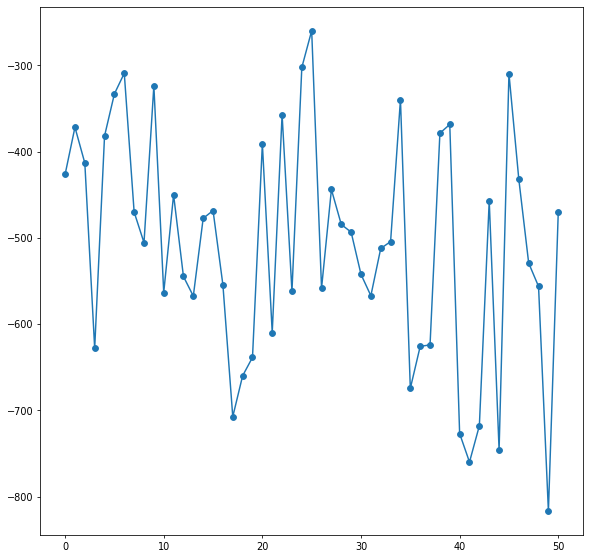

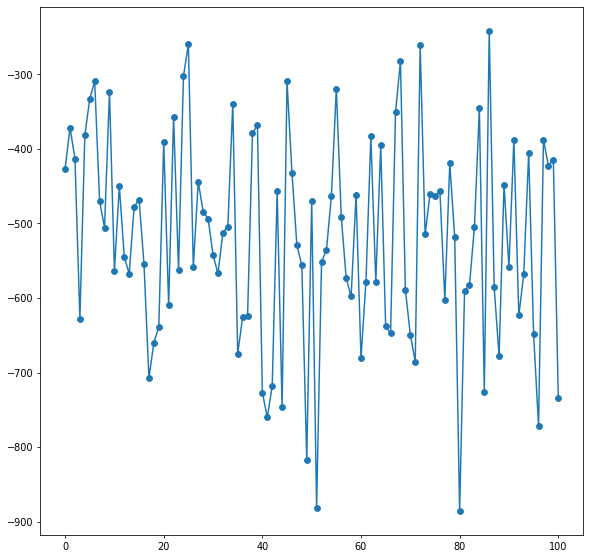

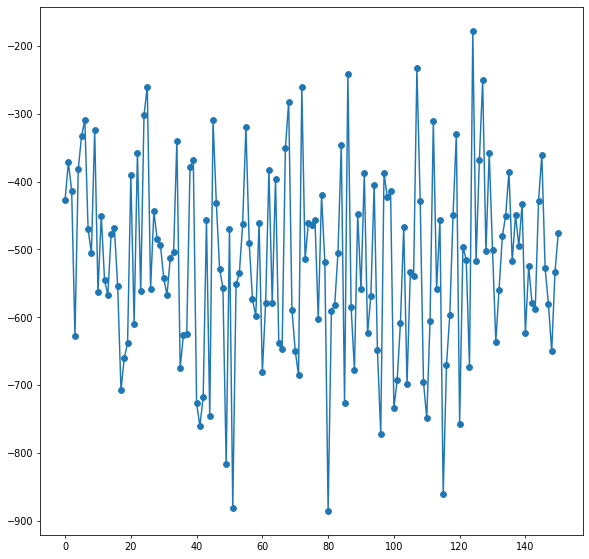

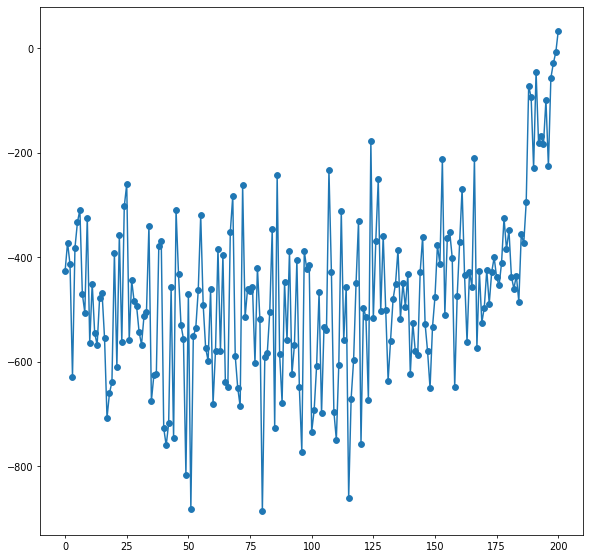

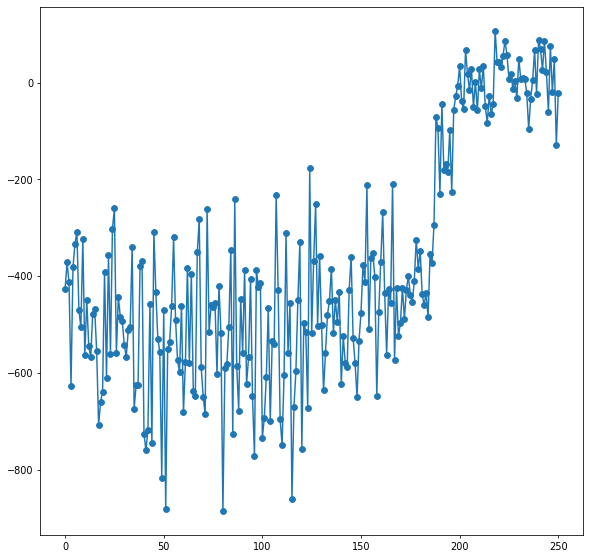

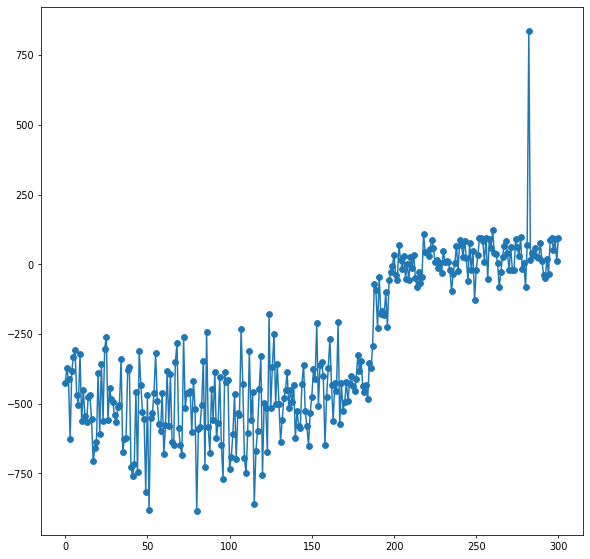

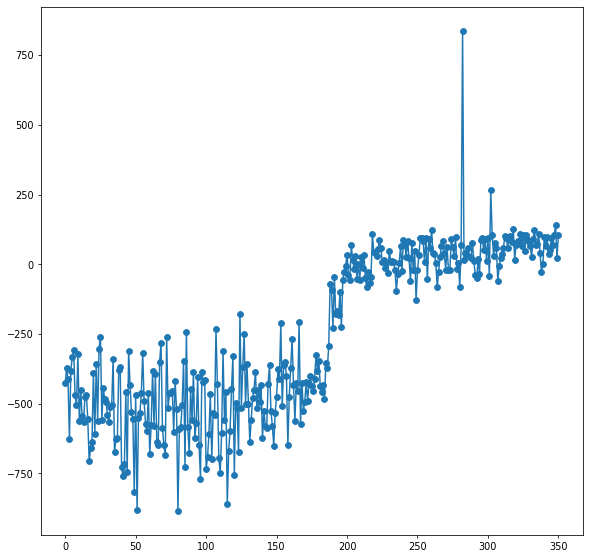

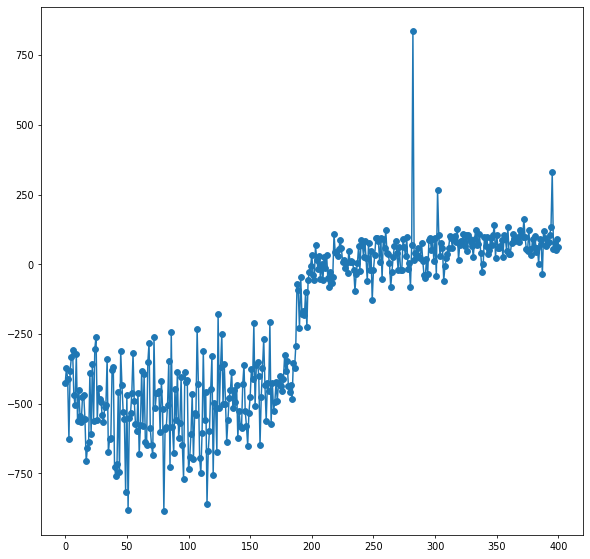

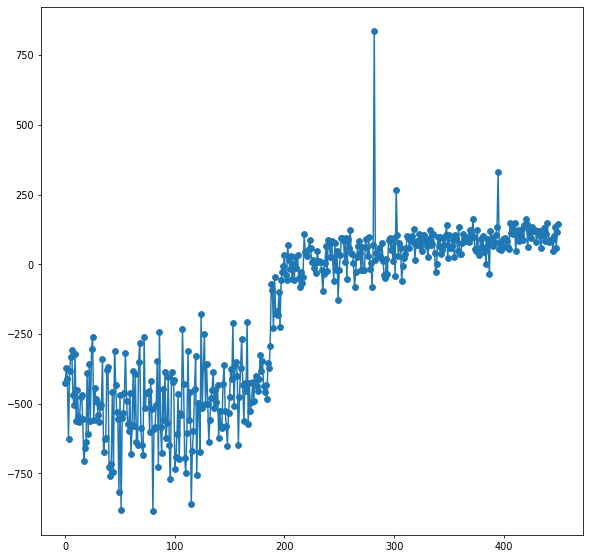

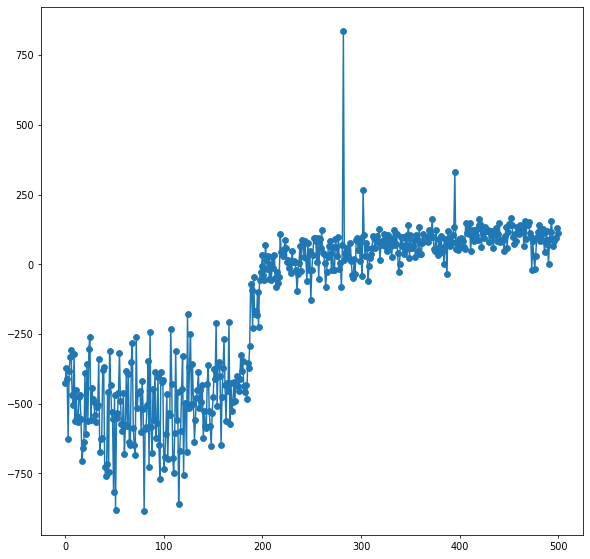

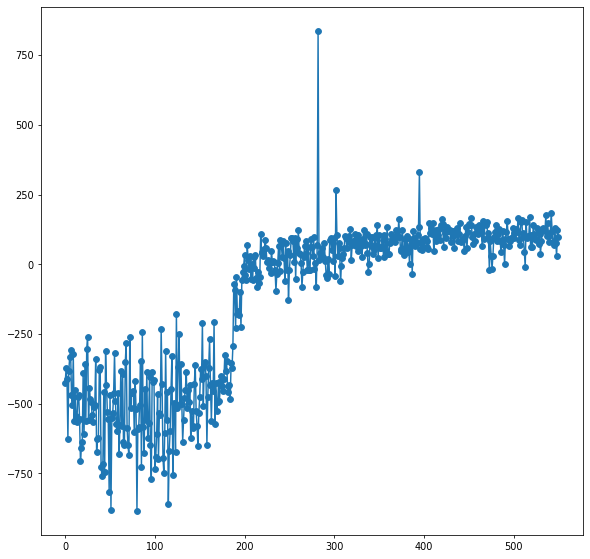

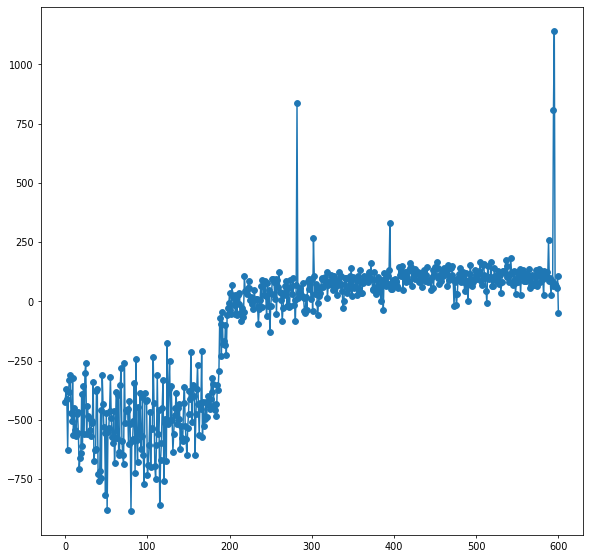

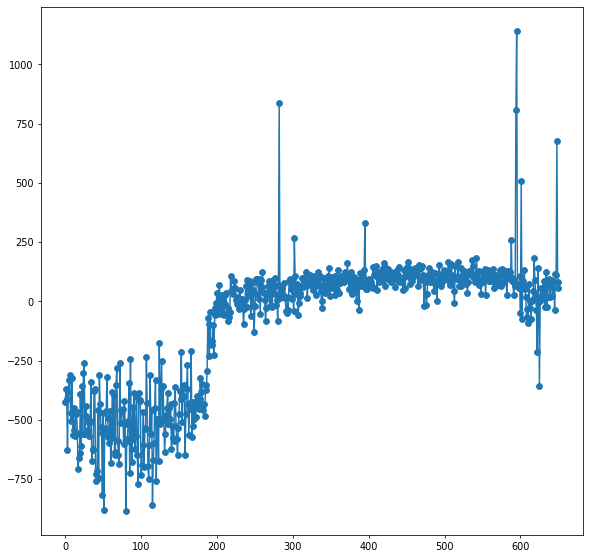

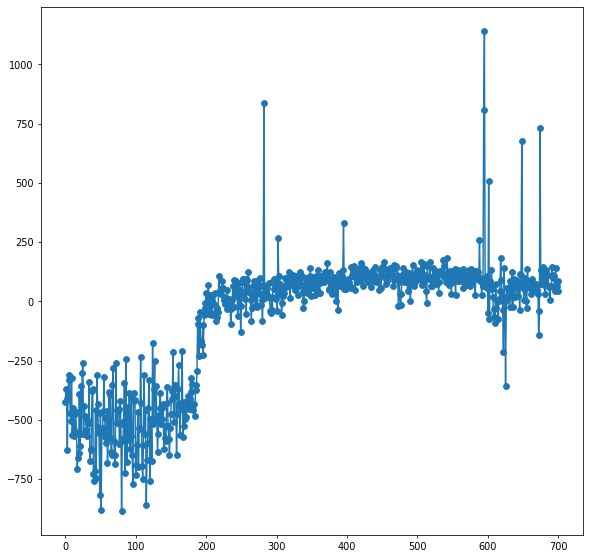

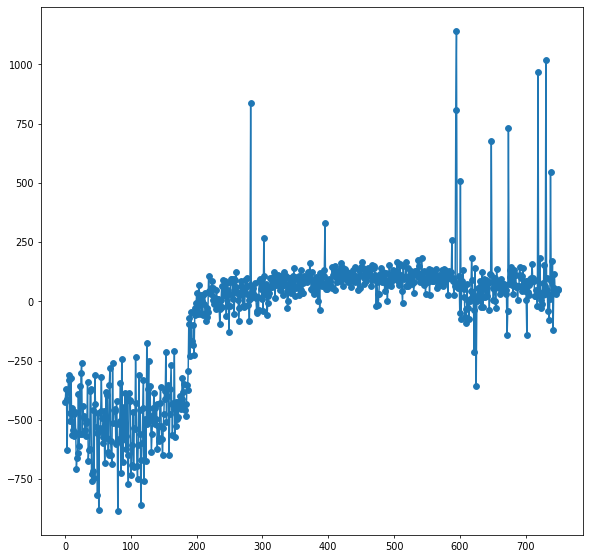

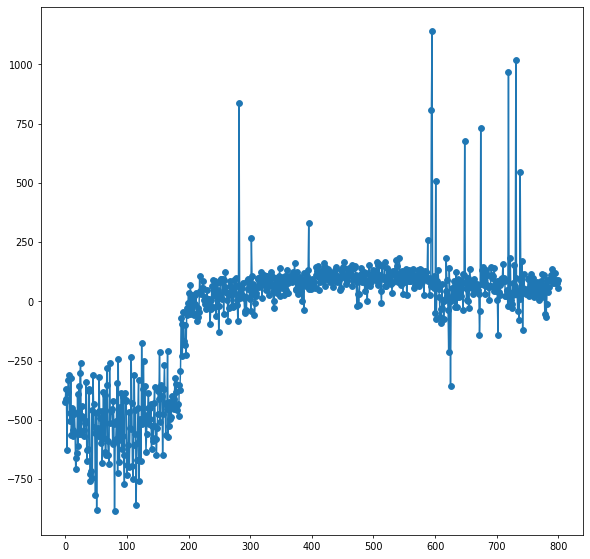

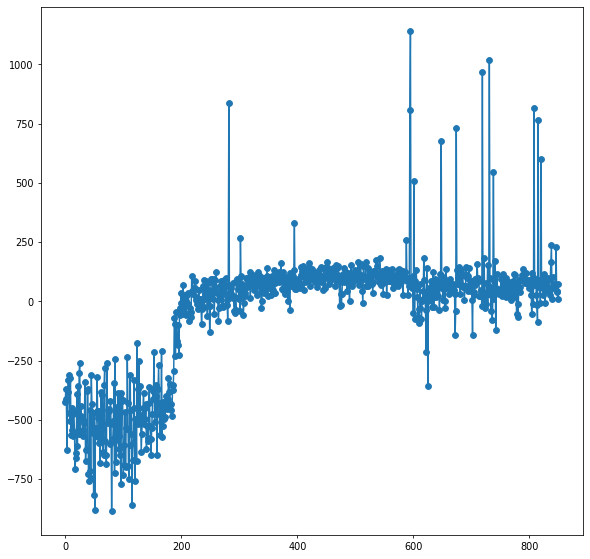

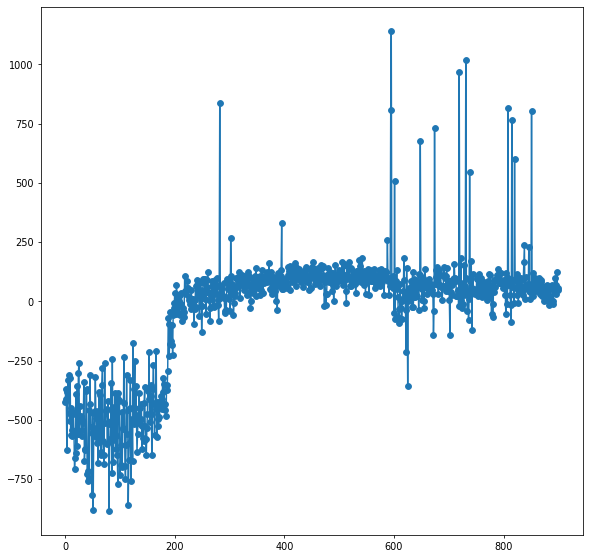

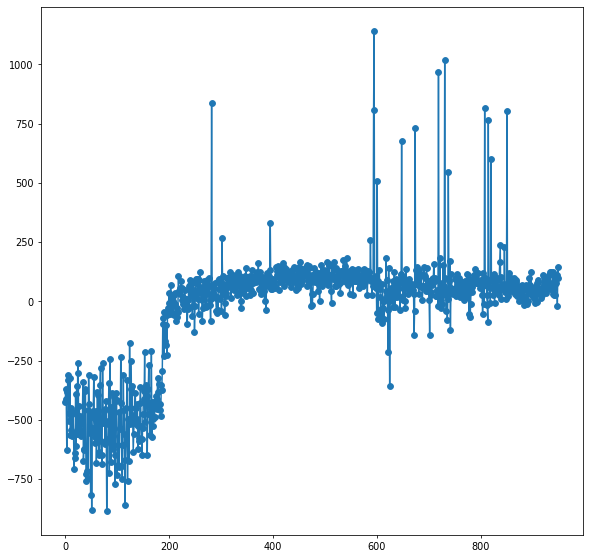

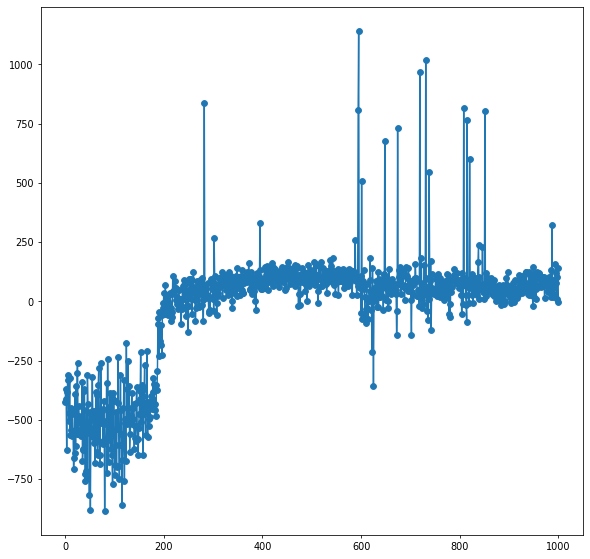

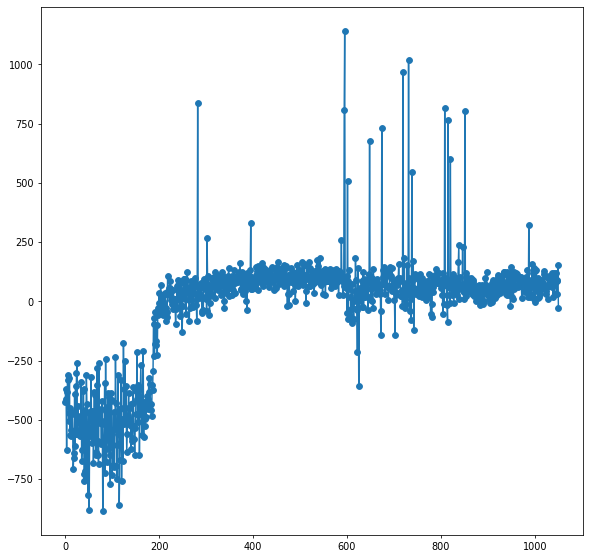

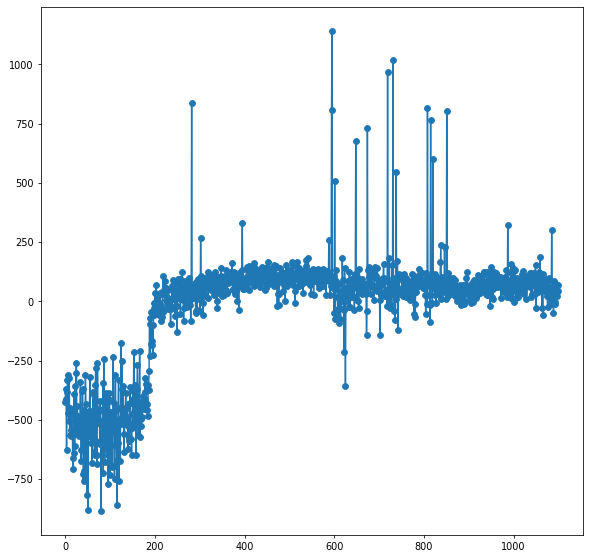

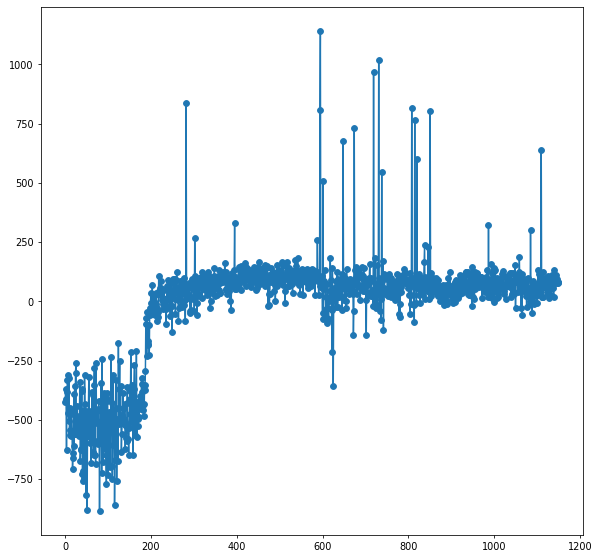

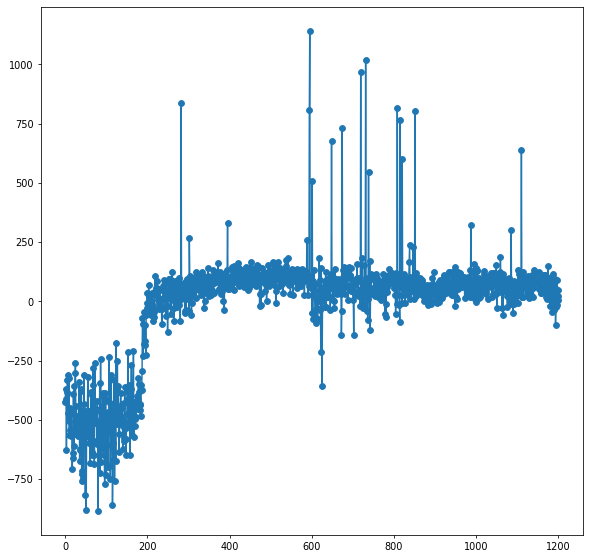

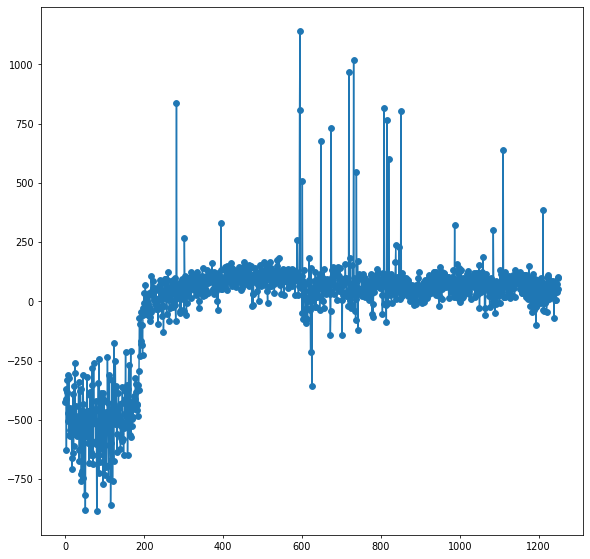

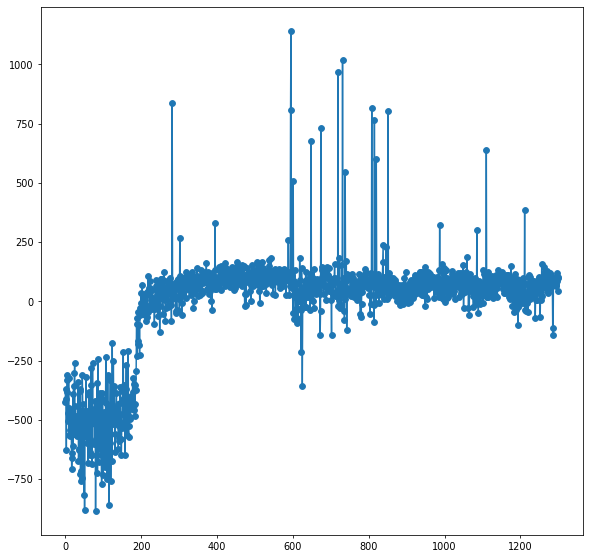

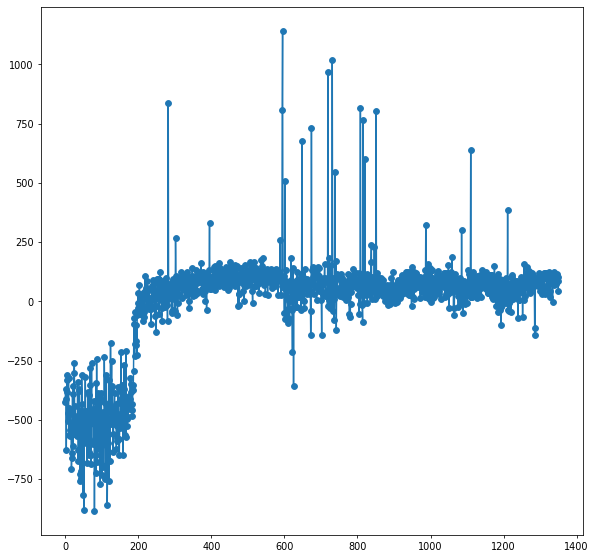

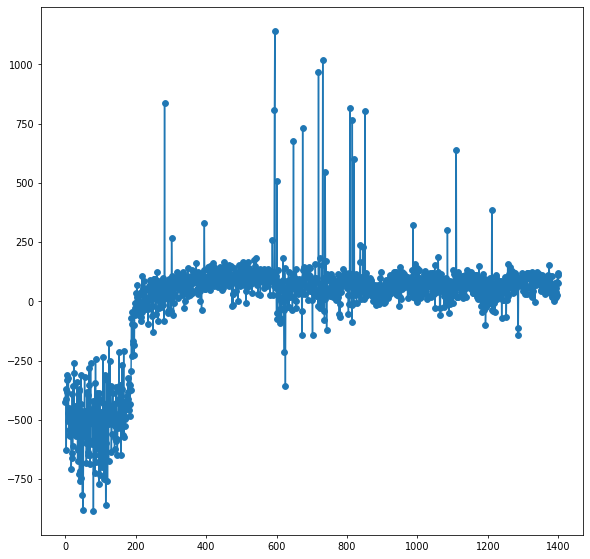

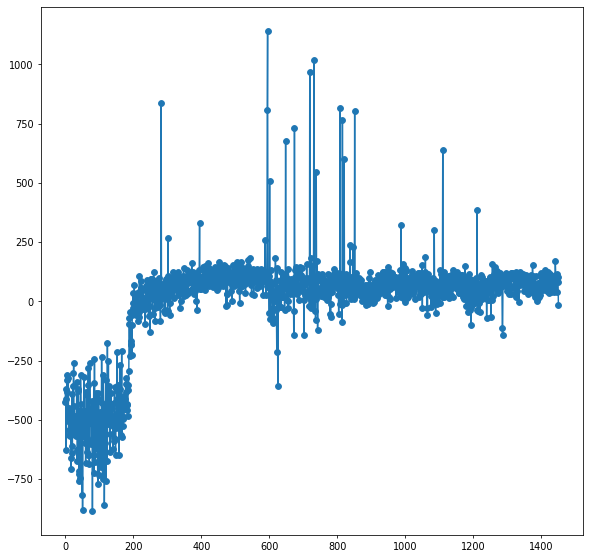

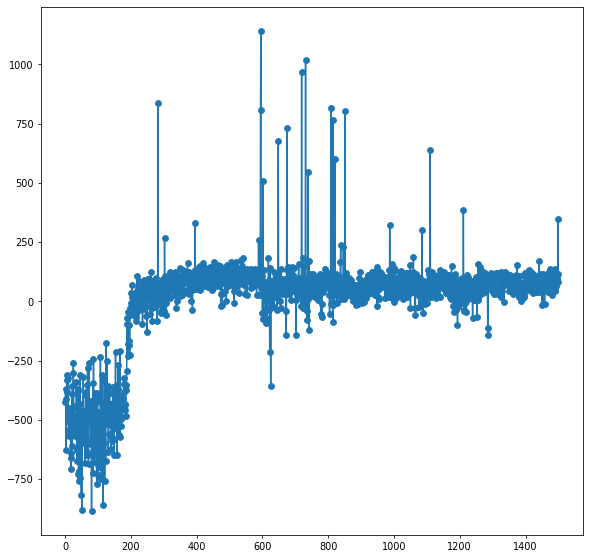

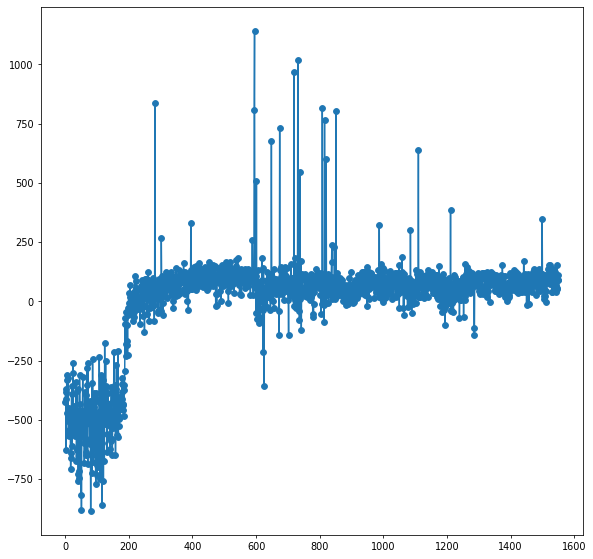

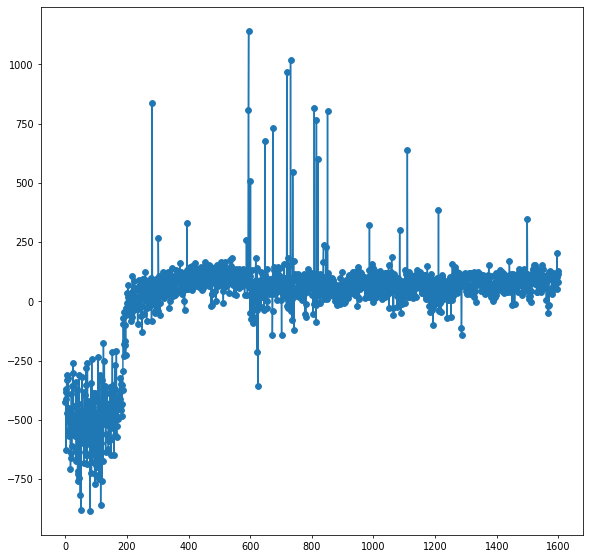

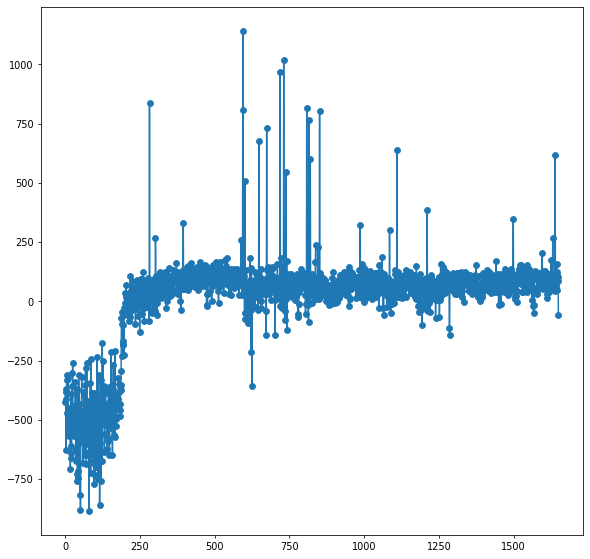

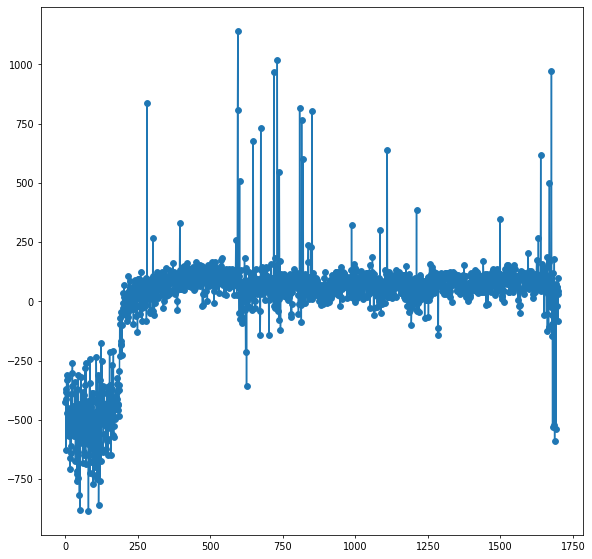

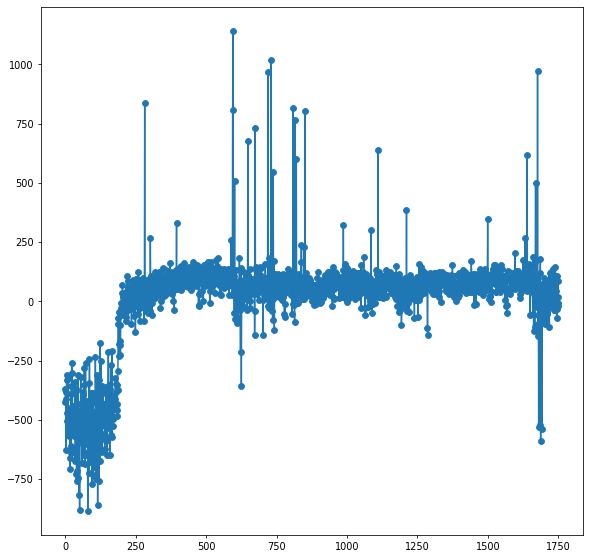

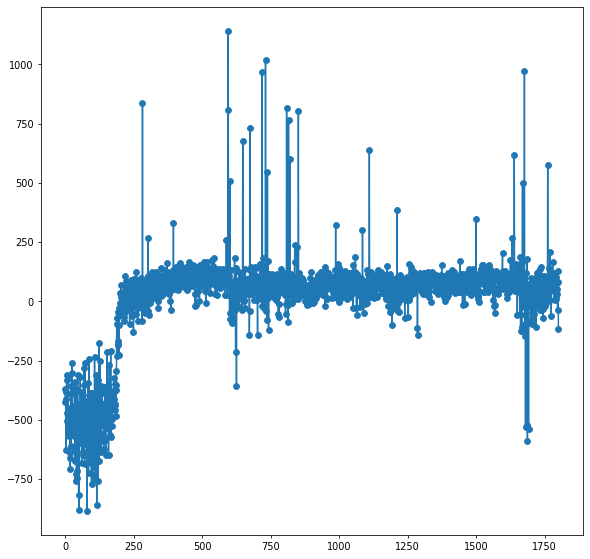

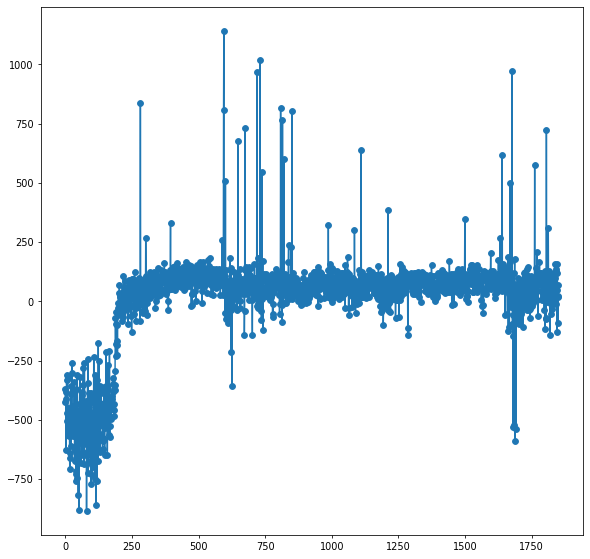

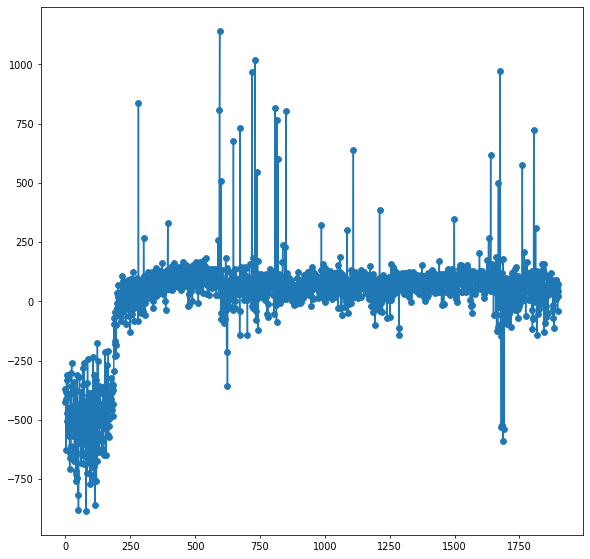

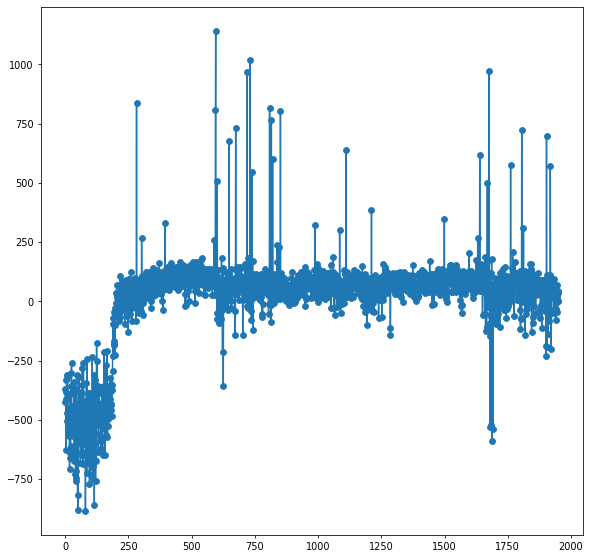

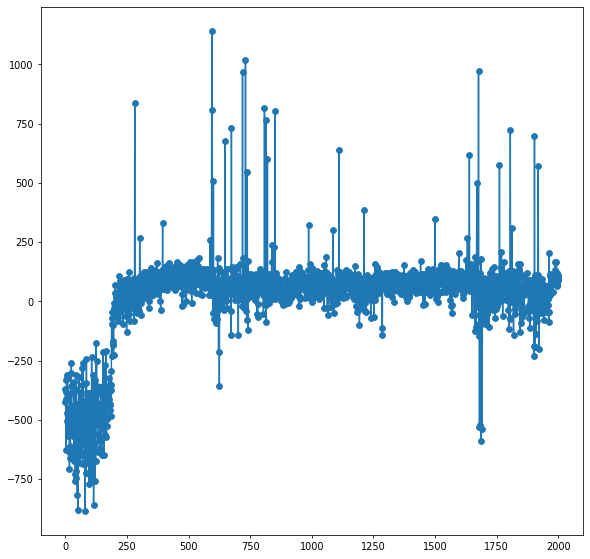

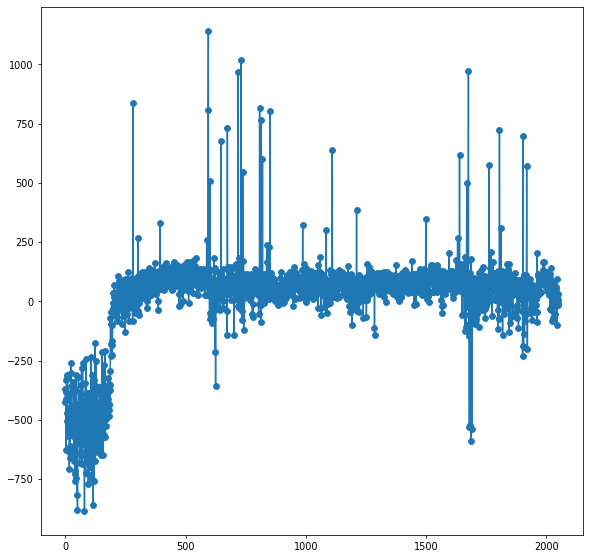

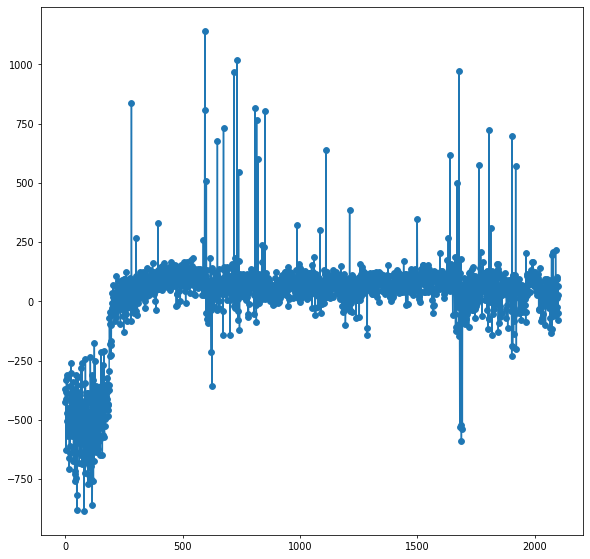

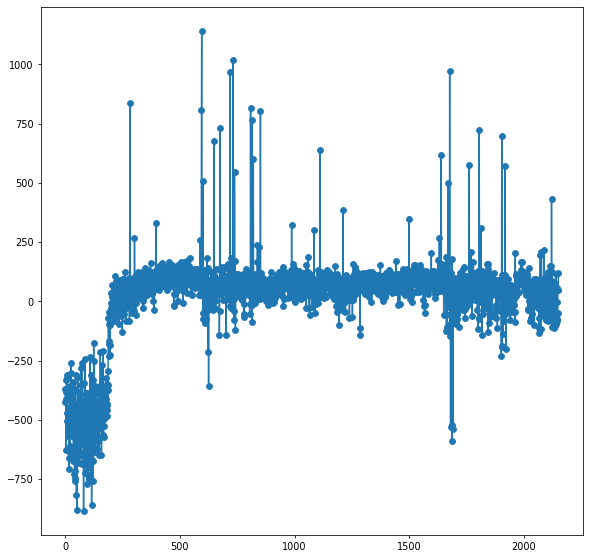

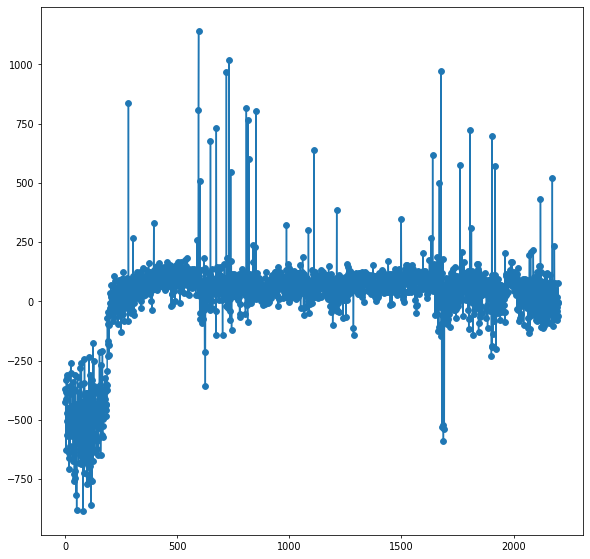

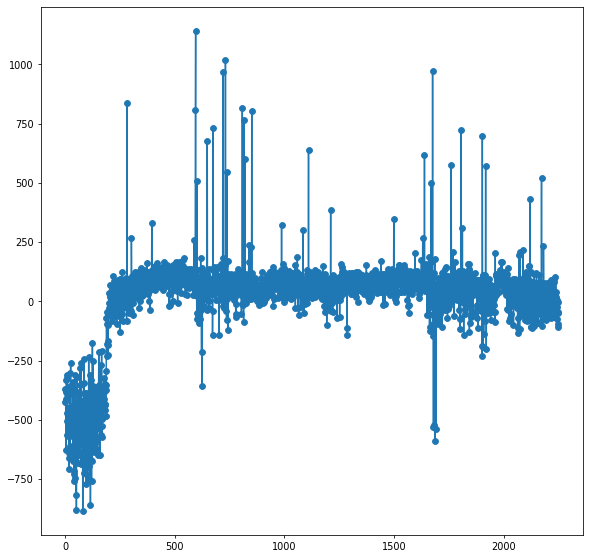

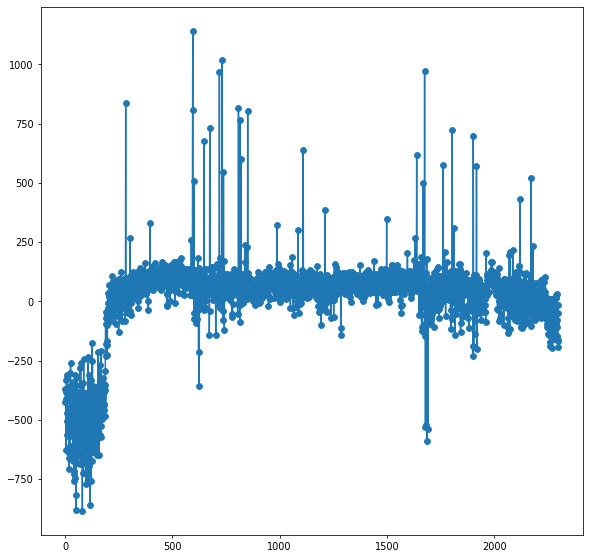

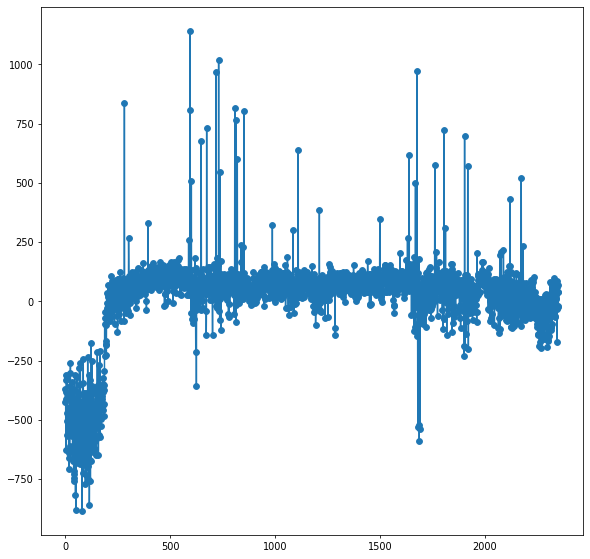

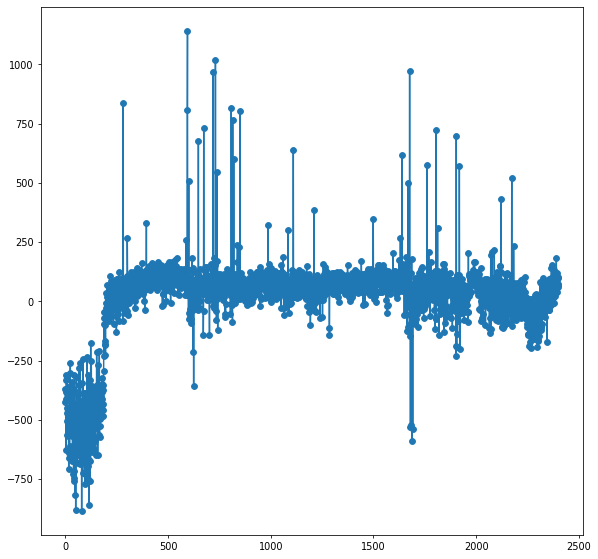

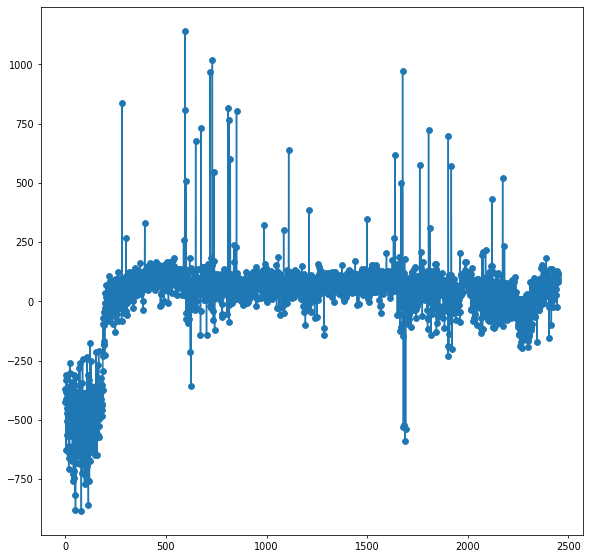

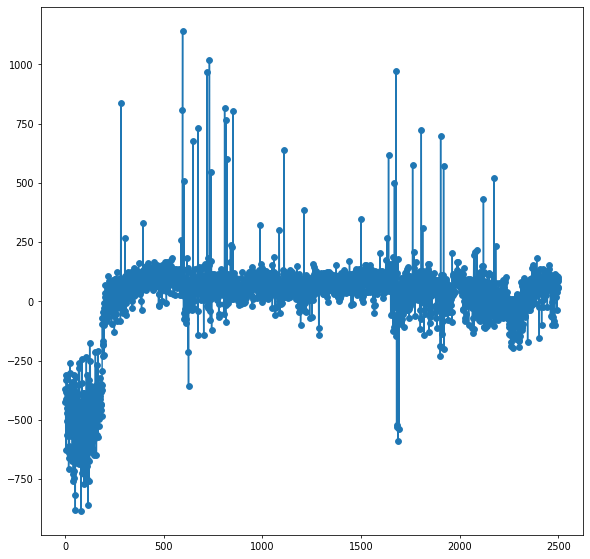

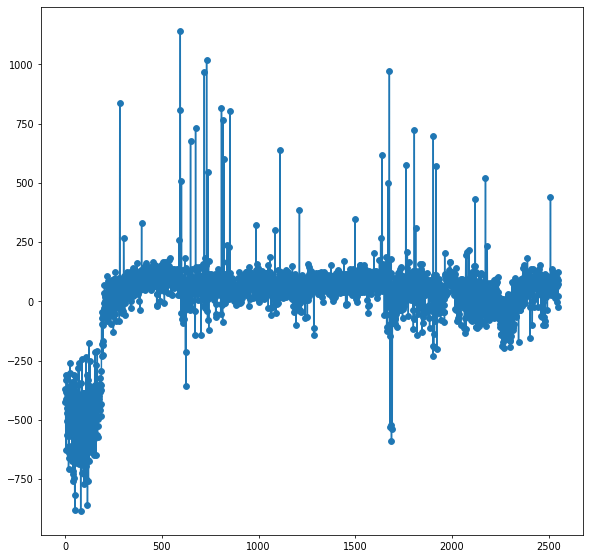

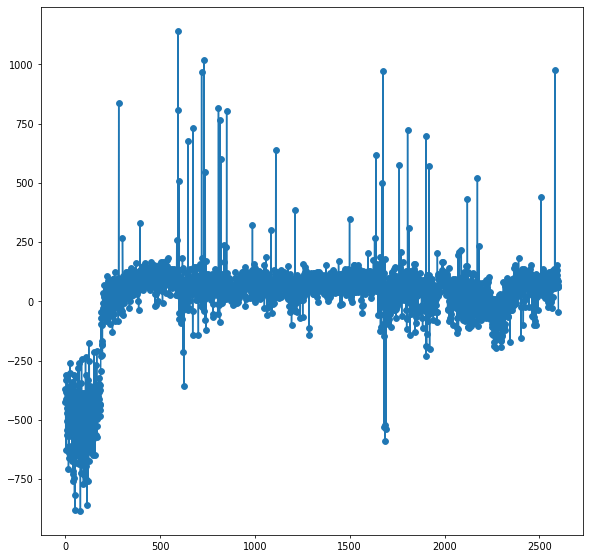

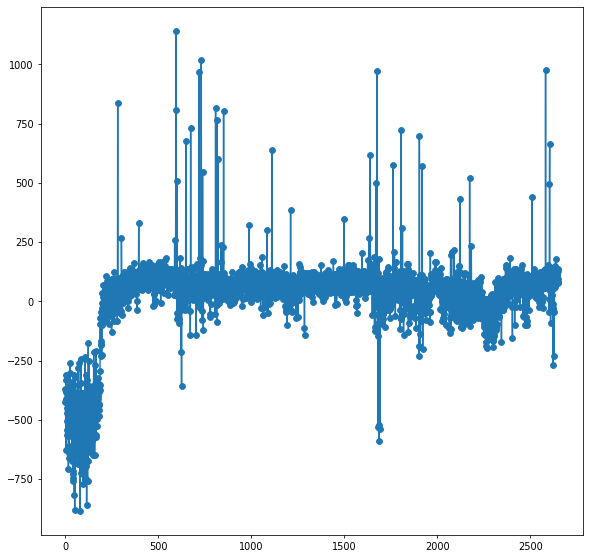

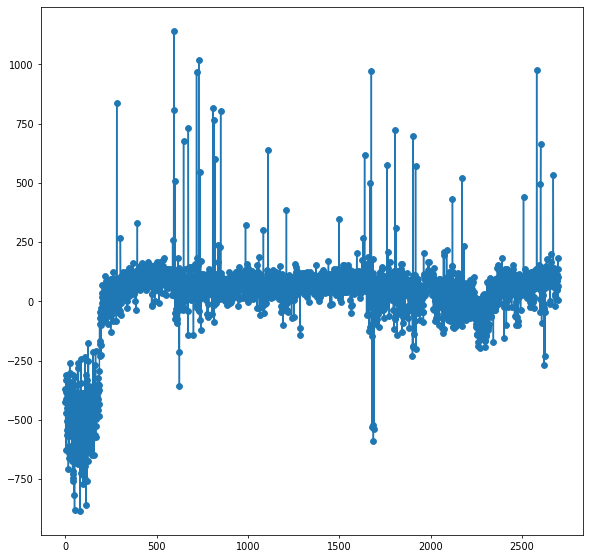

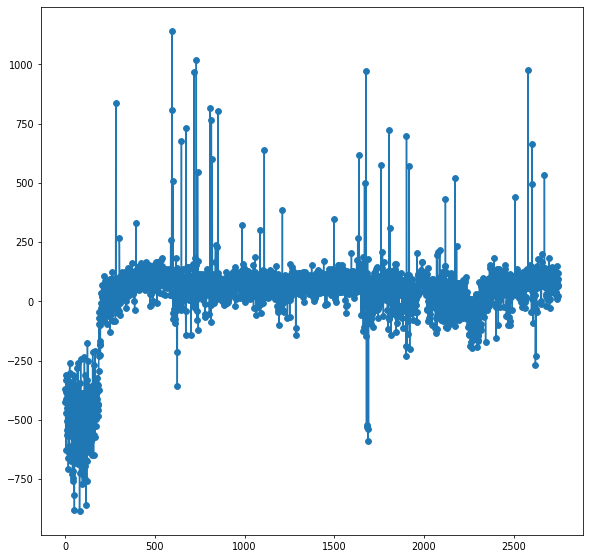

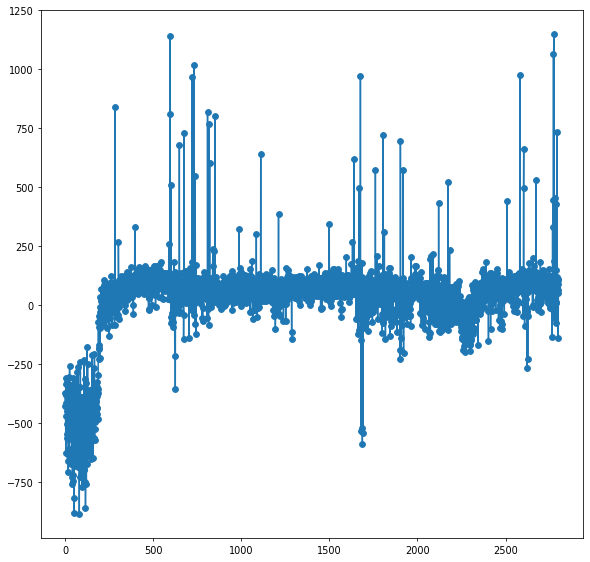

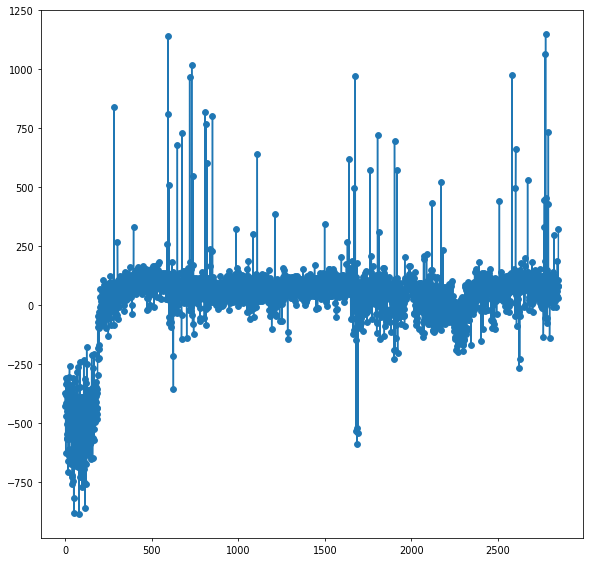

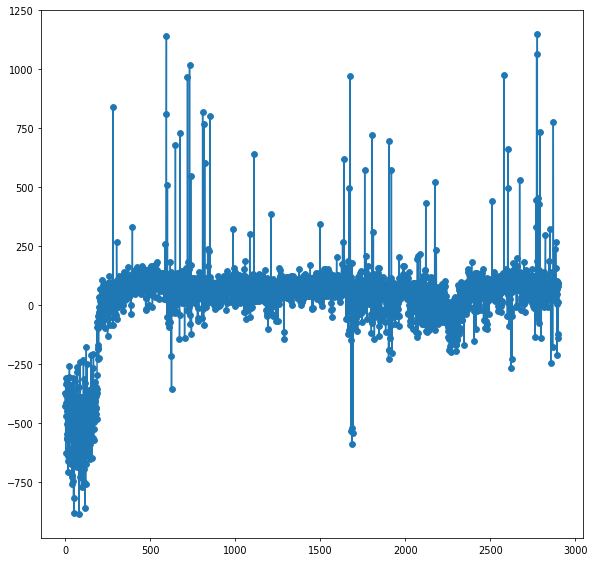

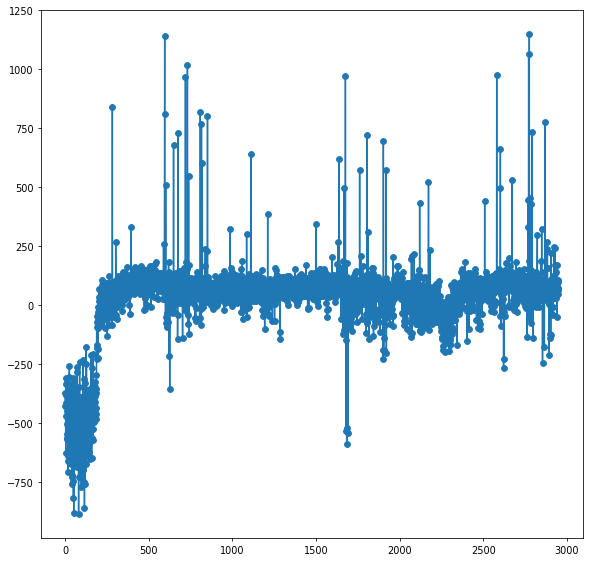

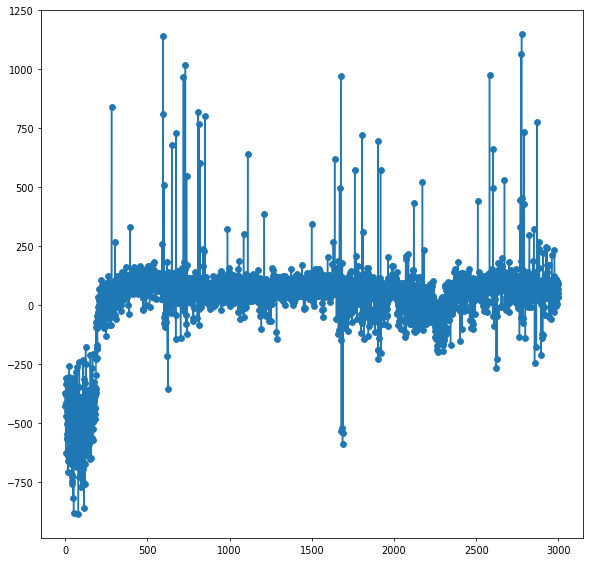

In [3]:
##############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                                             # 动作取值区间,对称区间，故只取上界
hidden_dim = 512
lr_a = 0.001
lr_c = 0.001
ddpg = DDPG(a_dim, s_dim, a_bound, hidden_dim)

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()


if LOAD_MODEL or LOAD_MEM:
    var = 0.1

if LOAD_PRETRAIN:
    var = 0.2

list = [1, 2, 7, 8, 9, 11, 14, 18, 33]
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    LEVEL = random.choice(list)
    s = env.reset(level = LEVEL)
    #s = env.reset(level = int(random.choice([1,2,7,8,9])))
    ep_reward = 0
    
    #if i > 500:
        
     #   if lr_a >= 0.000001:
      #      lr_a = lr_a - 0.0000001
       # if lr_c >= 0.000001:
        #    lr_c = lr_c - 0.0000001
    
    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            ddpg.Record_success(i)
            r += 100 #+200
        
        r += 10
        r = r * 200
        r+= 200
        r += info.get('qpos') * 4000
        #print(r)
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化
    
        
        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9995                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn(lr_a,lr_c)                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS -1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward/j), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward/j)
            
            #if ddpg.pointer > ddpg.memory_capacity and done:
                #RENDER = True
            if (i % CHECK_POINT_EPI) == 0 and i != 0:
                ddpg.save('level_selected_checkpoint/' + str(i) + 'epi')
            
            break
               
print('Running time: ', time.time() - t1)

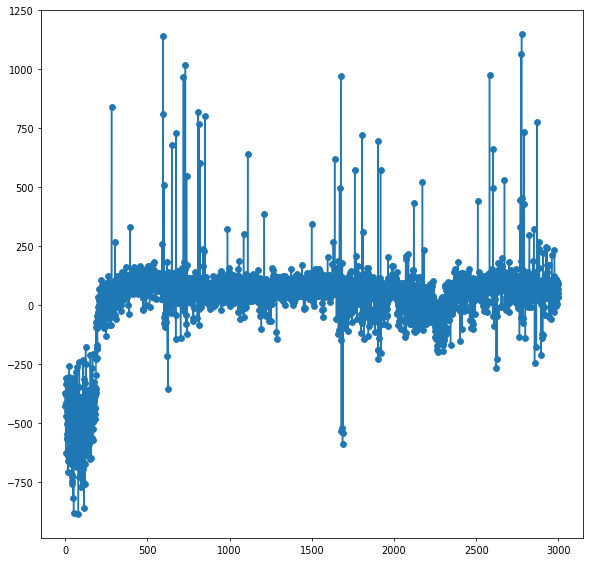

In [4]:
ddpg.save('carbinet_SELF_level_selected_3000EPS')

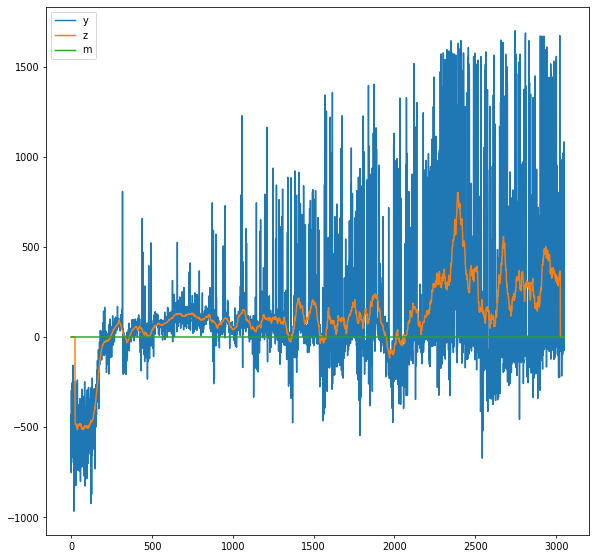

maximum success rate:  0.0
maximum mean rewards:  800.5924504191495


In [8]:
data = pd.read_csv('./DPG model/level12789_check_point_final/3050epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

size = 50

z = np.zeros(len(y))
m = np.zeros(len(y))

#for i in range(len(y)):
#    if y[i] >= 10:
#        y[i] = 0
        
for i in range(len(y)):
    
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward
            
            if(y[i + j - int(size/2)] == 0):
                m[i] += 1                  #success rate
            
                                   
            
        z[i] = z[i] / size
        m[i] = m[i]
        

    
    
plt.figure(figsize=(10, 10), dpi=70)

plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, m)

plt.legend(['y','z','m'])
plt.show()

print('maximum success rate: ', max(m)/50)
print('maximum mean rewards: ', max(z))

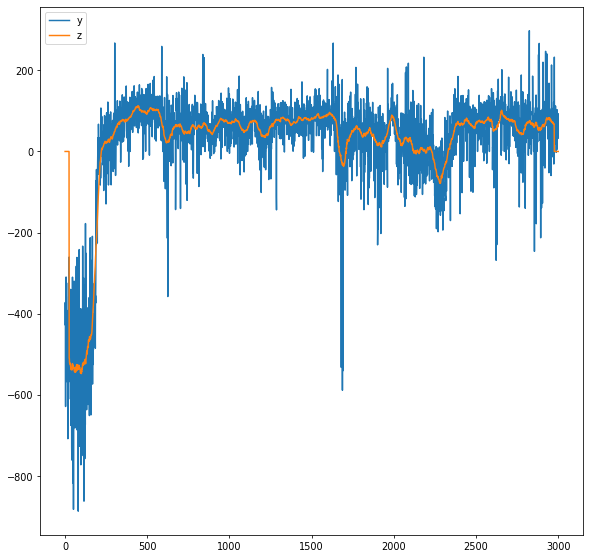

maximum mean rewards:  444


In [5]:
data = pd.read_csv('./DPG model/level_selected_checkpoint/3000epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])
size = 50
z = np.zeros(len(y))
for i in range(len(y)):
    if y[i] >= 300:
        y[i] = 0  
for i in range(len(y)):
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward        
    z[i] = z[i]/size
plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, y)
plt.plot(x, z)
plt.legend(['y','z'])
plt.show()
print('maximum mean rewards: ', np.argmax(z))

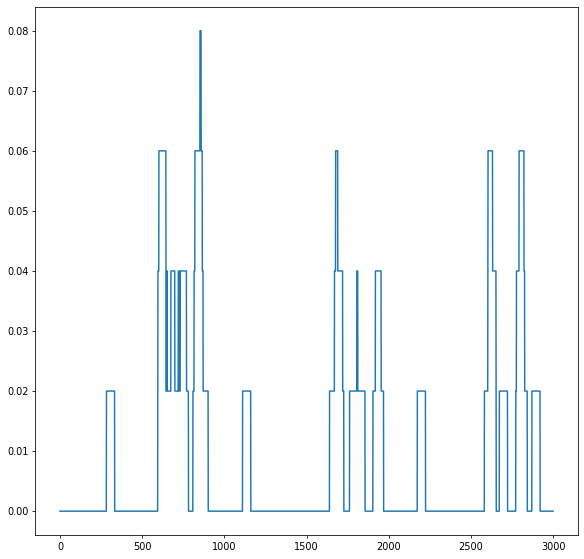

0.08
852


In [6]:
data = pd.read_csv('./DPG model/level_selected_checkpoint/3000epi/Success_record.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])
m = np.zeros(y.shape[0])

for i in range(50,3000):
    for j in range(50):
        if y[i-50+j] == 1:
            m[i] += 1
    m[i] = m[i] / 50   
    
plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, m)
plt.show()
print(max(m))#最大值
print(np.argmax(m))#最大值所在位置